# 시작
- https://velog.io/@gtpgg1013/pytorch-Image-Classification-Using-ViT  
참고해서 조금씩 수정하면서 사용

In [1]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import timm
import torch
import torch.nn as nn
from torchmetrics import Precision, Recall, F1Score
import matplotlib.pyplot as plt
import seaborn as sns

## 모델 정의

In [5]:
# model = timm.create_model('vit_base_patch32_clip_448.laion2b_ft_in12k_in1k', pretrained=True, in_chans=3, num_classes=5)

# x = torch.randn(3, 3, 448, 448)

# model(x).shape

In [6]:
model = timm.create_model('vit_base_patch16_224.orig_in21k', pretrained=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

classifier 층은 직접 정의

In [18]:
model.head = nn.Sequential(
	nn.BatchNorm1d(768),
	nn.Linear(in_features=768, out_features=512, bias=False),
	nn.ReLU(),
	nn.BatchNorm1d(512),
	nn.Dropout(0.4),
	nn.Linear(in_features=512, out_features=2, bias=False))

In [19]:
# 모델의 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

Total Parameters: 86195456


In [20]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

해상도가 224, 224가 아니어도 괜찮은건가 확인 필요

## 데이터 불러오기

In [23]:
import torch
from torchvision import datasets, transforms

# 이미지가 있는 폴더 경로
data_dir = '/content/drive/MyDrive/eardrum2/data_2_vs'

# 데이터셋을 로드하고 변환 적용
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지 정규화
])

# 이미지 폴더 데이터셋 생성
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=data_transform)
val_dataset = datasets.ImageFolder(root=data_dir + '/val', transform=data_transform)
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=data_transform)

# 클래스 이름 확인
train_class = train_dataset.classes
val_class = val_dataset.classes
test_class = test_dataset.classes
print("Class Names:", train_class)
print("Class Names:", val_class)

# 데이터로더 생성 (필요에 따라 배치 크기 및 셔플 설정 가능)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# 데이터셋 사용 예시
for inputs, labels in val_dataloader:
    # inputs: 배치 이미지 데이터
    # labels: 해당 이미지의 라벨 (클래스)
    print(inputs.shape, labels)

Class Names: ['Abnormal', 'Normal']
Class Names: ['Abnormal', 'Normal']
torch.Size([16, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([16, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])
torch.Size([16, 3, 224, 224]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([16, 3, 224, 224]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([16, 3, 224, 224]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([16, 3, 224, 224]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([10, 3, 224, 224]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [24]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(31, 7, 7)

In [25]:
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## loss function & Optimizer

In [26]:
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## train

In [27]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

# epochs = 10
# best_acc = 0.0

# for epoch in range(epochs):
#     print("{}/{} epoch running now".format(epoch + 1, epochs))

#     for phase in ['train', 'val']:
#         if phase == 'train':
#             model.train()
#         else:
#             model.eval()

#         running_loss = 0.0
#         running_corrects = 0
#         total_samples = 0

#         for inputs, labels in dataloaders_dict[phase]:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()

#             # requires_grad = True, when Training
#             with torch.set_grad_enabled(phase == 'train'):
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 if phase == 'train':
#                     # 손실 계산 (각 Tensor의 gradient 계산)
#                     loss.backward()
#                     # 계산된 손실을 optimizer의 계산에 따라 weight 조정
#                     optimizer.step()

#             total_samples += inputs.size(0)
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         if phase == 'train':
#             exp_lr_scheduler.step()

#         epoch_loss = running_loss / total_samples
#         epoch_acc = running_corrects.double() / total_samples

#         print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#         # 모델 저장
#         if phase == 'val' and epoch_acc > best_acc :
#             best_acc = epoch_acc
#             torch.save(model.state_dict(), './best_model.pth')

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# 클래스가 3개인 상황 설정
num_classes = 2

# 메트릭 초기화
# 메트릭 초기화
precision_metric = Precision(num_classes=num_classes, average='macro', task='multiclass').to(device)
recall_metric = Recall(num_classes=num_classes, average='macro', task='multiclass').to(device)
f1_metric = F1Score(num_classes=num_classes, average='macro', task='multiclass').to(device)

# 기록을 저장할 리스트들 초기화하기
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

min_loss = 0
epochs = 50

for epoch in range(epochs):
    print("{}/{} epoch running now".format(epoch + 1, epochs))

    # 메트릭 리셋
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in dataloaders_dict[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            total_samples += inputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # 메트릭 업데이트
            precision_metric(preds, labels)
            recall_metric(preds, labels)
            f1_metric(preds, labels)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        # 계산된 메트릭값 가져오기
        precision = precision_metric.compute()
        recall = recall_metric.compute()
        f1 = f1_metric.compute()

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(
            phase, epoch_loss, epoch_acc, precision, recall, f1))

        if phase == 'val' and epoch_loss < min_loss:
            min_loss = epoch_loss
            torch.save(model.state_dict(), './best_model.pth')


1/50 epoch running now
train Loss: 0.6833 Acc: 0.6826 Precision: 0.6281 Recall: 0.6727 F1: 0.6277
val Loss: 0.5543 Acc: 0.7642 Precision: 0.6140 Recall: 0.6397 F1: 0.6194
2/50 epoch running now
train Loss: 0.5886 Acc: 0.7178 Precision: 0.6311 Recall: 0.6571 F1: 0.6383
val Loss: 0.4958 Acc: 0.7736 Precision: 0.6236 Recall: 0.6310 F1: 0.6268
3/50 epoch running now
train Loss: 0.4968 Acc: 0.7759 Precision: 0.6903 Recall: 0.7108 F1: 0.6987
val Loss: 0.4956 Acc: 0.7736 Precision: 0.6807 Recall: 0.6749 F1: 0.6776
4/50 epoch running now
train Loss: 0.4598 Acc: 0.8008 Precision: 0.7151 Recall: 0.6917 F1: 0.7015
val Loss: 0.6527 Acc: 0.6415 Precision: 0.6817 Recall: 0.6909 F1: 0.6859
5/50 epoch running now
train Loss: 0.5121 Acc: 0.7780 Precision: 0.6745 Recall: 0.6385 F1: 0.6507
val Loss: 0.6603 Acc: 0.7736 Precision: 0.6713 Recall: 0.6162 F1: 0.6299
6/50 epoch running now
train Loss: 0.4324 Acc: 0.8008 Precision: 0.7157 Recall: 0.6661 F1: 0.6828
val Loss: 0.8055 Acc: 0.3868 Precision: 0.6351 

## inference

In [29]:
# 모델을 평가 모드로 설정
model.eval()

# 그라디언트 계산 비활성화
with torch.no_grad():
    running_corrects = 0
    total_samples = 0

    # 메트릭 초기화
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델 예측
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        total_samples += inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 메트릭 업데이트
        precision_metric(preds, labels)
        recall_metric(preds, labels)
        f1_metric(preds, labels)

    # 최종 정확도 계산
    test_acc = running_corrects.double() / total_samples

    # 계산된 메트릭값 가져오기
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    f1 = f1_metric.compute()

    print('Test Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(test_acc, precision, recall, f1))

Test Acc: 0.8208 Precision: 0.8457 Recall: 0.6338 F1: 0.6590


In [ ]:
train_acc_history_cpu = [x.cpu().numpy() for x in train_acc_history]
val_acc_history_cpu = [x.cpu().numpy() for x in val_acc_history]

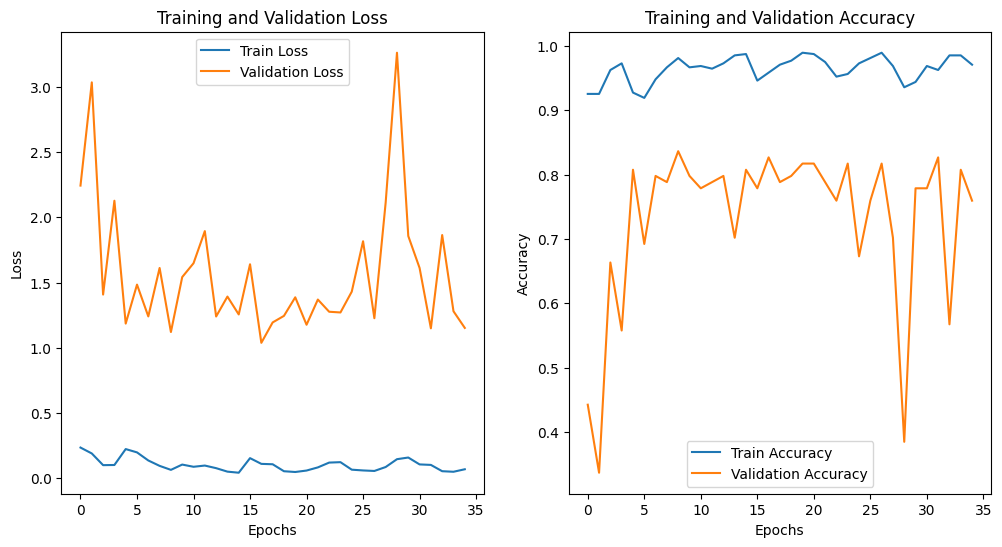

In [ ]:
# 학습이 끝난 후 손실과 정확도 그래프를 그립니다.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(train_acc_history, label='Train Accuracy')
# plt.plot(val_acc_history, label='Validation Accuracy')
plt.plot(train_acc_history_cpu, label='Train Accuracy')
plt.plot(val_acc_history_cpu, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
import torch
from sklearn.metrics import confusion_matrix

# 모델 평가 모드로 전환
model.eval()

# 예측값과 실제 라벨을 저장할 리스트 초기화
all_predictions = []
all_labels = []

# 테스트 데이터셋을 이용하여 예측값과 실제 라벨 수집
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 혼동 행렬 계산
conf_mat = confusion_matrix(all_labels, all_predictions)
print('Confusion Matrix:')
print(conf_mat)

Confusion Matrix:
[[14  4  0]
 [27 54  0]
 [ 3  4  0]]


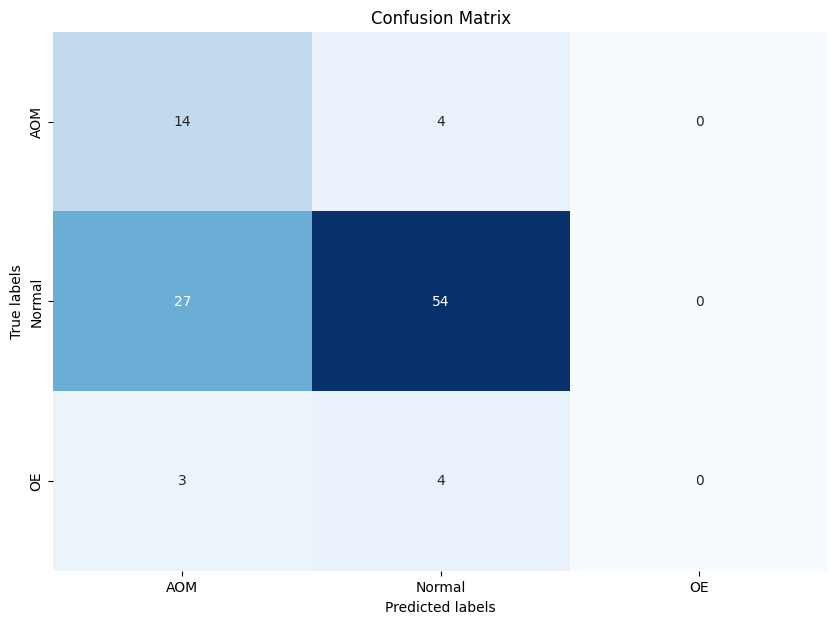

In [ ]:
# 클래스 레이블 이름
class_names = ['AOM', 'Normal', 'OE']

# 혼동 행렬을 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names) # 클래스 이름을 x축과 y축에 적용
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()